In [1]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
from sklearn.decomposition import PCA, SparsePCA
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn import preprocessing
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer

pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv('strava_dmatrix.csv', index_col=0)

In [3]:
df.head()

,metro,strava id,Decoded Polyline,Buffered Polyline,building - industrial,highway - residential,highway - service,highway - cycleway,surface - asphalt,power - substation,...,bridge - movable,surface - pebblestone,crossing - pedestrian_signals,place - plot,sport - skiing,sidewalk - yes,power - office,surface - sand,parking - street_side,sport - ice_hockey;ice_skating
0,Philadelphia,4709431.0,"[(39.93771, -75.16854), (39.9367, -75.16874), ...","POLYGON ((-75.16864190475492 39.936680575199, ...",1.0,5.0,3.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Philadelphia,27581807.0,"[(39.95798, -75.17566), (39.95889, -75.17549),...",POLYGON ((-75.17558857203231 39.95890690438281...,0.0,8.0,4.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Philadelphia,17297769.0,"[(39.99362, -75.21742), (39.99366, -75.2173), ...","POLYGON ((-75.2173316227766 39.9937548683298, ...",0.0,4.0,2.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Philadelphia,16871702.0,"[(39.94239, -75.19863), (39.94247, -75.19869),...",POLYGON ((-75.19876087633354 39.94239783511138...,0.0,0.0,5.0,0.0,21.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Philadelphia,9259454.0,"[(39.99507, -75.21355), (39.99499, -75.21387),...",POLYGON ((-75.21492836120809 39.99485335178647...,0.0,1.0,3.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df.duplicated().any()

False

In [5]:
df_feat = df.iloc[:, 4:]
df_feat.head()

,building - industrial,highway - residential,highway - service,highway - cycleway,surface - asphalt,power - substation,access - private,landuse - industrial,landuse - brownfield,landuse - construction,...,bridge - movable,surface - pebblestone,crossing - pedestrian_signals,place - plot,sport - skiing,sidewalk - yes,power - office,surface - sand,parking - street_side,sport - ice_hockey;ice_skating
0,1.0,5.0,3.0,1.0,1.0,1.0,2.0,3.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,8.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,4.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,5.0,0.0,21.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,3.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df_feat.shape

(1050, 399)

In [7]:
len(df_feat)

1050

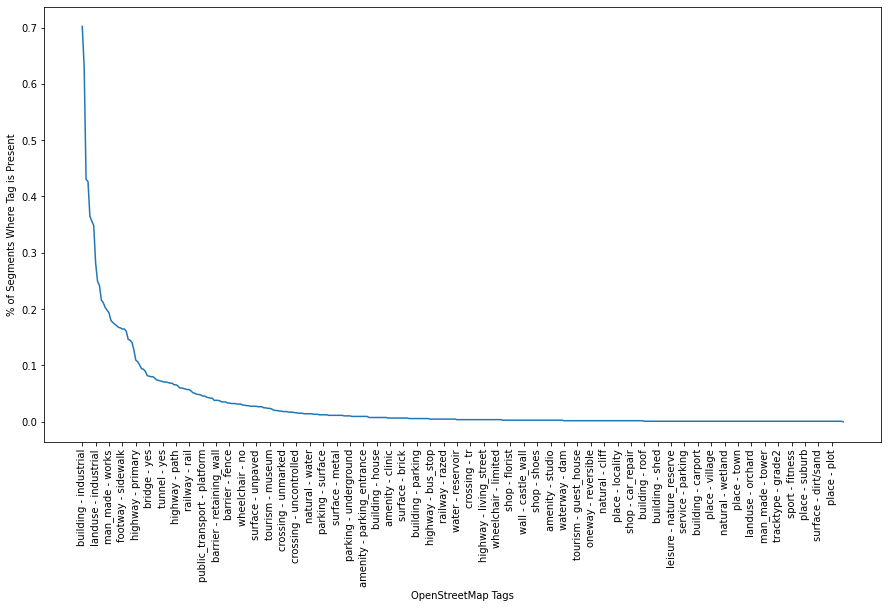

In [8]:
plt.figure(figsize=(15,8))
((df_feat != 0).sum()/len(df_feat)).sort_values(ascending=False).plot()
plt.xticks(ticks=range(0, df_feat.shape[1], 7), labels=df_feat.columns[::7])
plt.xticks(rotation=90)
plt.xlabel('OpenStreetMap Tags')
plt.ylabel('% of Segments Where Tag is Present')
plt.savefig('tag_counts.png', bbox_inches='tight')
plt.show()

In [9]:
keys = [k[0] for k in df_feat.columns.str.split(' -')]
df_keys = df_feat.copy()
df_keys.columns = keys

## How many segments does each key appear in?

In [10]:
key_list = []
key_sums = []

for k in set(keys):
    key_list.append(k)
    if type(df_keys[k]) == pd.DataFrame:
        key_sum = (df_keys[k].sum(axis=1) != 0).sum()
    else:
        key_sum =(df_keys[k] != 0).sum()
    key_sums.append(key_sum)  

In [11]:
key_counts = pd.Series(key_sums, index=key_list)

In [12]:
key_counts.sort_values(ascending=False).head()

highway     1038
surface      575
oneway       519
service      460
building     435
dtype: int64

In [13]:
# For every key, see if there are any keys where every segment count falls below the threshold

In [14]:
rare_cutoff = 15

In [15]:
key_check = []

for k in set(keys):
    if ((df_keys[k] != 0).sum() < rare_cutoff).all():
        key_check.append(k)

In [16]:
key_check

['sport', 'shop', 'wall', 'tracktype']

### Keep it simple: drop tags below cutoff

In [17]:
segment_freq = (df_feat != 0).sum().sort_values(ascending=False)

In [18]:
segment_freq = segment_freq[segment_freq >= rare_cutoff]

In [19]:
len(segment_freq)

121

In [20]:
to_keep = segment_freq.index

In [21]:
df_feat = df_feat[to_keep]

## Scale the data with Tfidf 

In [22]:
segment_freq = segment_freq.to_dict()

In [23]:
# segment_freq

In [24]:
def tf_idf(x):
    
    def nest_tf(y):
        return y
    
    tag_count = x.apply(nest_tf)
    seg_count = segment_freq[x.name]
    seg_total = df_feat.shape[0]
    
    return tag_count * np.log(seg_total/seg_count)
#     return tag_count * (seg_total/seg_count)

In [25]:
tf_df = df_feat.apply(tf_idf)

In [26]:
tf_df.head()

,highway - residential,highway - service,highway - footway,oneway - yes,surface - asphalt,highway - tertiary,building - yes,footway - sidewalk,service - driveway,highway - crossing,...,service - yard,waterway - canal,amenity - shelter,highway - tertiary_link,leaf_cycle - deciduous,foot - permissive,natural - scrub,service - spur,barrier - bollard,landuse - forest
0,1.769788,1.383840,0.000000,0.000000,1.008510,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.831660,1.845120,10.114359,6.814018,1.008510,0.000000,7.377385,3.798558,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.415830,0.922560,0.000000,3.407009,1.008510,0.000000,1.053912,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,2.306399,16.014402,11.924531,21.178720,0.000000,1.053912,12.661860,0.0,12.772901,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.353958,1.383840,0.842863,3.407009,4.034042,2.064579,3.161736,1.266186,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
tf_df.columns.to_series(index=range(len(df_feat.columns))).to_csv('feature_list.csv')

In [28]:
# (tf_df == 0).sum().sort_values()

In [29]:
# Show which features contain deflated values

In [30]:
(tf_df >= df_feat).all().head(10)

highway - residential    False
highway - service        False
highway - footway        False
oneway - yes             False
surface - asphalt         True
highway - tertiary        True
building - yes            True
footway - sidewalk        True
service - driveway        True
highway - crossing        True
dtype: bool

In [31]:
tf_df.max().sort_values(ascending=False).head()

natural - tree                237.094833
building - yes                186.542443
crossing - traffic_signals    179.175212
amenity - bench               157.926983
highway - street_lamp         136.411300
dtype: float64

In [32]:
comp_df = pd.DataFrame({'Before tf-idf': df_feat.max(axis=0),
                        'After tf-idf': round(tf_df.max(axis=0), 1)})

In [33]:
comp_df[3:8]

,Before tf-idf,After tf-idf
oneway - yes,30.0,25.6
surface - asphalt,24.0,24.2
highway - tertiary,18.0,18.6
building - yes,177.0,186.5
footway - sidewalk,50.0,63.3


In [34]:
comp_df[3:8].to_csv('tf-idf_comp.csv')

In [35]:
tf_df.to_csv('tf_df.csv')